In [1]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib as mpl
import scienceplots
import pandas as pd

from src import CARPoolSimulations
from src import CARPoolEmulator

In [2]:
def extract_params(line):
    params = line.split(' ')[1:29]
    params.append(line.split(' ')[35])
    return np.array(params, dtype='float')
def BS_organizer(N, thetas):
    theta_S = []
    theta_B = []
    for i, theta in zip(N, thetas):
        if (i//128)%2 ==0:
            theta_B.append(theta)
        elif (i//128)%2 ==1:
            theta_S.append(theta)
        else:
            raise Exception("Somethings totally wrong")
    return np.array(theta_B), np.array(theta_S)
    
def BS_matcher(N_B, N_S, base, surrogate):
    bases, surrogates = [], []
    #match bases with surrogates
    for i, b in enumerate(N_B):
        if b+128 in N_S:
            bases.append(i)
            j = np.where(b+128 == N_S)[0][0]
            surrogates.append(j)
    #create list of bases and surrogates, non-pairs at the end
    if len(bases) > 0 and len(surrogates) > 0:
        base = np.concatenate((base[np.array(bases)], base[np.delete(np.arange(len(base)), bases)]))
        surrogate = np.concatenate((surrogate[np.array(surrogates)], surrogate[np.delete(np.arange(len(surrogate)), surrogates)]))
    return base, surrogate

In [3]:
LR       = 1e-5

with open('Data/PARAMS.txt', 'r') as file:
    lines = file.readlines()
theta_raw = np.array([extract_params(line) for line in lines])
theta = theta_raw.copy()
param_info = pd.read_csv('Data/SB28_param_minmax.csv')
#Normalize parameters
for i, t in enumerate(theta_raw[:, :-1].T):
    if bool(param_info['LogFlag'][i]):
        theta[:, i] = np.log10(theta_raw[:, i])




In [4]:
file = open('distance_mass_bins.txt','r')
lines = file.readlines()

In [5]:
emu_list = [[],[],[],[],[]]
theta_min = np.array(param_info['MinVal']).astype('float')
theta_max = np.array(param_info['MaxVal']).astype('float')

theta_min = np.append(theta_min,12)
theta_max = np.append(theta_max,15)

for i in range(len(theta_min)-1):
    if bool(param_info['LogFlag'][i]):
        theta_min[i] = np.log10(theta_min[i])
        theta_max[i] = np.log10(theta_max[i])

for distance_bin in range(5):
    for mass_bin in range(3):
        
        data = np.array([float(line.split()[3*distance_bin+mass_bin+3]) for line in lines])
        
        usable_indices = ~np.isnan(data)
        
        quenched = data[usable_indices]
        halo_masses = np.log10(np.array([float(line.split()[1]) for line in lines])[usable_indices])
        zoom_num = np.array([int(line.split()[0]) for line in lines])[usable_indices]
        
        usable_theta = theta[zoom_num]
        usable_theta[:,-1] = halo_masses
        usable_theta_normalized = (usable_theta - theta_min) / (theta_min - theta_max) + 1
        
        theta_B, theta_S  = BS_organizer(zoom_num, usable_theta_normalized)
        Q_B, Q_S          = BS_organizer(zoom_num, quenched) 
        N_B, N_S          = BS_organizer(zoom_num,zoom_num)
        Q_B, Q_S          = BS_matcher(N_B, N_S, Q_B, Q_S)
        theta_B, theta_S  = BS_matcher(N_B, N_S, theta_B, theta_S)
        
        # Create simulation objects and surrogate objects
        sims = CARPoolSimulations.Simulation()
        surrs = CARPoolSimulations.Simulation()
        
        # Set the parameters and quantities for these simulations
        sims.parameters  = theta_B  ;  sims.quantities  = Q_B
        surrs.parameters = theta_S  ;  surrs.quantities = Q_S
        
        #Build an emulator object (this generates the kernels which you can find in the CARPoolKernels file) 
        emu = CARPoolEmulator.Emulator(sims, surrs)
        
        params = {"scaleV"   :.5*np.ones(emu.param_dimensions),
                "scaleX" :.5*np.ones(emu.param_dimensions),
                "scaleW" : .5*np.ones(emu.param_dimensions),
                "scaleM" :.5*np.ones(emu.param_dimensions),
                "log_ampV"   :0.0*np.ones(emu.param_dimensions),
                "log_ampW"   :0.0*np.ones(emu.param_dimensions),
                "log_ampX"   :0.0*np.ones(emu.param_dimensions),                
                "log_deltaP" :0*np.ones(emu.param_dimensions),
                "log_jitterV":-2.0,
                "log_jitterW":-2.0,
                "log_mean"   :-1.0}
        
        best_params = emu.train(params,learning_rate=LR*1e1, max_iterations=10000)
        emu_list[distance_bin].append(emu)

(0.0, 1.0)

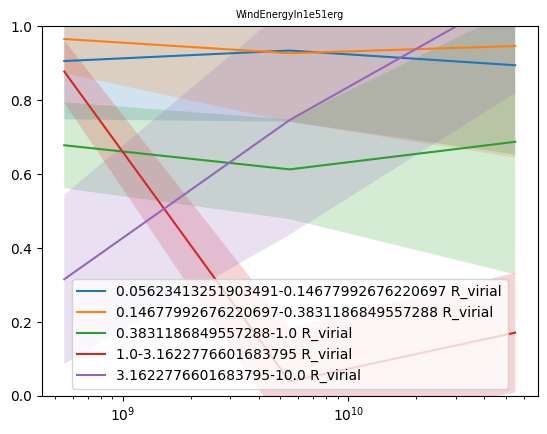

In [7]:
fig,ax = plt.subplots()
P = 2


theta_test = np.ones((5, 29)) * 0.5
theta_test[:, P] = np.linspace(0, 1, 5)
theta_test[:, 0] = (0.3089 - theta_min[0]) / (theta_min[0] - theta_max[0]) + 1
theta_test[:, 7] = (0.0491 - theta_min[7]) / (theta_min[7] - theta_max[7]) + 1


mean_list = [[],[],[],[],[]]
variance_list = [[],[],[],[],[]]
x = (theta_test[:, P] - 1) * (theta_min[P] - theta_max[P]) + theta_min[P]
if P<28:
    if bool(param_info['LogFlag'][P]) == True:
        x = 10**x

for distance_bin in range(5):
    for mass_bin in range(3):
        pred_mean, pred_var = emu_list[distance_bin][mass_bin].predict(theta_test)
        mean_list[distance_bin].append(pred_mean)
        variance_list[distance_bin].append(np.diag(pred_var))

mean_list = np.array(mean_list)
diag = np.array(variance_list)


if bool(param_info['LogFlag'][P]) == True:
    norm = mpl.colors.LogNorm(vmin=float(param_info['MinVal'][P]),vmax=float(param_info['MaxVal'][P]))
else:
    norm = mpl.colors.Normalize(vmin=float(param_info['MinVal'][P]),vmax=float(param_info['MaxVal'][P]))
cmap = plt.cm.jet

sm = pl.cm.ScalarMappable(cmap=cmap,norm=norm)

bins = np.logspace(8,11,4)
x2 = np.array([(bins[i]+bins[i+1])/2 for i in range(len(bins)-1)])

#for value in range(len(x)):
value = 2

distance_bins = np.concatenate((np.logspace(-1.25,0,4),np.logspace(0,1,3)[1:]))
for distance_bin in range(5):
    line = mean_list[distance_bin][:,value]
    error = diag[distance_bin][:,value]**(.5)
    ax.plot(x2, line, label = str(distance_bins[distance_bin])+'-'+str(distance_bins[distance_bin+1])+' R_virial')
    ax.fill_between(x2, line-error, line+error, alpha=0.2)

ax.legend()
ax.set_title(param_info['ParamName'][P], fontsize = 7)
#fig.colorbar(sm, orientation='vertical', ax = ax)
ax.set_xscale('log')
ax.set_ylim(0,1)

Text(0, 0.5, 'Loss')

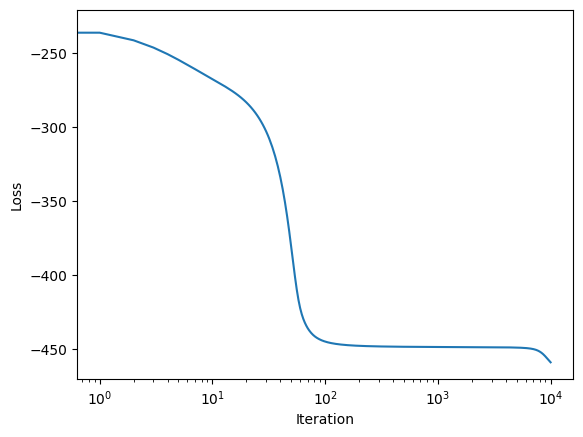

In [18]:
plt.semilogx(emu_list[0][0].losses[-1])
plt.xlabel('Iteration')
plt.ylabel('Loss')

In [ ]:
emu_list[0].param_evolution[-1]

In [30]:
lines = np.array([line.split() for line in lines])